# Truecolor_2: learning from daytime examples

In the previous colab [Truecolor_1](https://colab.research.google.com/drive/1y0N03UwmJvHiUy4V4mcQajDFLPbADJJa?authuser=2#scrollTo=_J9K8zJzg66J), we generated a "cloud mask" from the GOES blue channel and overlaid it on a static world map.

The key idea here is pretty simple.  We will train a machine learning model to _predict_ the cloud mask from only the IR channels 8--16.  Since the IR channels remain present at night, we can use the predicted cloud mask instead of the true mask at night.

# Colab setup

In [0]:
!pip install -U -q dateparser netcdf4 xarray pyresample "google-api-core>=1.11" "google-cloud-core>=1" "google-cloud-storage>=1.16" scikit-image tensorflow

from google.colab import auth
auth.authenticate_user()

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import netCDF4  # netCDF4 *must* be imported before tensorflow
import numpy as np
import logging
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import tensorflow as tf
from tensorflow import keras
import time
import urllib
import xarray

import google.cloud.storage as gcs

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

TRAIN_PATH = 'gs://weather-datasets/goes_truecolor/examples/train.tfrecord*'
TEST_PATH = 'gs://weather-datasets/goes_truecolor/examples/test.tfrecord*'

TMP_DIR = tempfile.mkdtemp('Truecolor_2')

# Generating a cloud mask training set

The first step is to create the training dataset.  This is is a moderately large task, so we implement it as a beam pipeline running on GCP.  The implementation is in the file [goes_truecolor/beam/make_truecolor_examples.py](https://github.com/jyh/goes_truecolor/blob/master/goes_truecolor/beam/make_truecolor_examples.py).

For this project, the training datasets was partitioned as follows.

+ For **training**, select every second day from 2018, at 17:00UTC (full daylight).
+ For **validation**, select every third day from January through May 2019, 17:00UTC (full daylight).

To generate Tensorflow examples, the first step is to generate the actual cloud mask from the blue channel, as well as the sequence of IR channels.  Note that the satellite is not always operational, so the processor returns early if there is no data.

    logging.info('creating cloud mask image %s', t)
    mask_img = self.reader.cloud_mask(t)
    if mask_img is None:
      return
    mask_img, _ = mask_img
    logging.info('creating IR image for %s', t)
    ir = self.reader.raw_image(t, self.ir_channels)
    if ir is None:
      return
    ir, _ = ir
    
At this point, the `mask_img` contains the cloud mask, and `ir` contains the 9 IR channels 8..16.  The next step is to convert these to Tensorflow examples.  We break the data into 64x64 tiles, using np.split.  Each tile is a `tf.train.Example` with two features, `cloud-mask` and `ir-channels`.  Each tile is yielded as a serialized `tf.train.Example`.

    logging.info('creating tiles for %s', t)
    partitions = self.image_size // self.tile_size
    mask_rows = np.split(mask_img, partitions, axis=0)
    ir_rows = np.split(ir, partitions, axis=0)
    for mask_row, ir_row in zip(mask_rows, ir_rows):
      mask_tiles = np.split(mask_row, partitions, axis=1)
      ir_tiles = np.split(ir_row, partitions, axis=1)
      for mask_tile, ir_tile in zip(mask_tiles, ir_tiles):
        features = {
            hparams.CLOUD_MASK_FEATURE_NAME: tf.train.Feature(
                int64_list=tf.train.Int64List(value=mask_tile.ravel())),

            hparams.IR_CHANNELS_FEATURE_NAME:  tf.train.Feature(
                int64_list=tf.train.Int64List(value=ir_tile.ravel())),
        }
        example = tf.train.Example(features=tf.train.Features(feature=features))
        yield example.SerializeToString()
        
This pipeline is run with the following command.

    $ python -m goes_truecolor.beam.make_truecolor_examples --runner=DataflowRunner
    
The output are stored in TFRecord files, `gs://bucket-name/goes_truecolor_examples/train.tfrecord-NNNNN-of-00032` and `gs://bucket-name/goes_truecolor_examples/test.tfrecord-NNNNN-of-00032`,


# Viewing the training dataset

Let's look at some example training data.  Tensorflow uses the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) package for reading data.  The datset reader follows a typical pattern:

+ The record files are read using `tf.data.TFRecordDataset`.
+ The individual examples are parser with `tf.parse_single_example`, and the `parse_fn` function performs any data conversion or resampling.

In the following display, the first three tiles in each row represent the IR channels, and the rightmost row is the cloud mask.


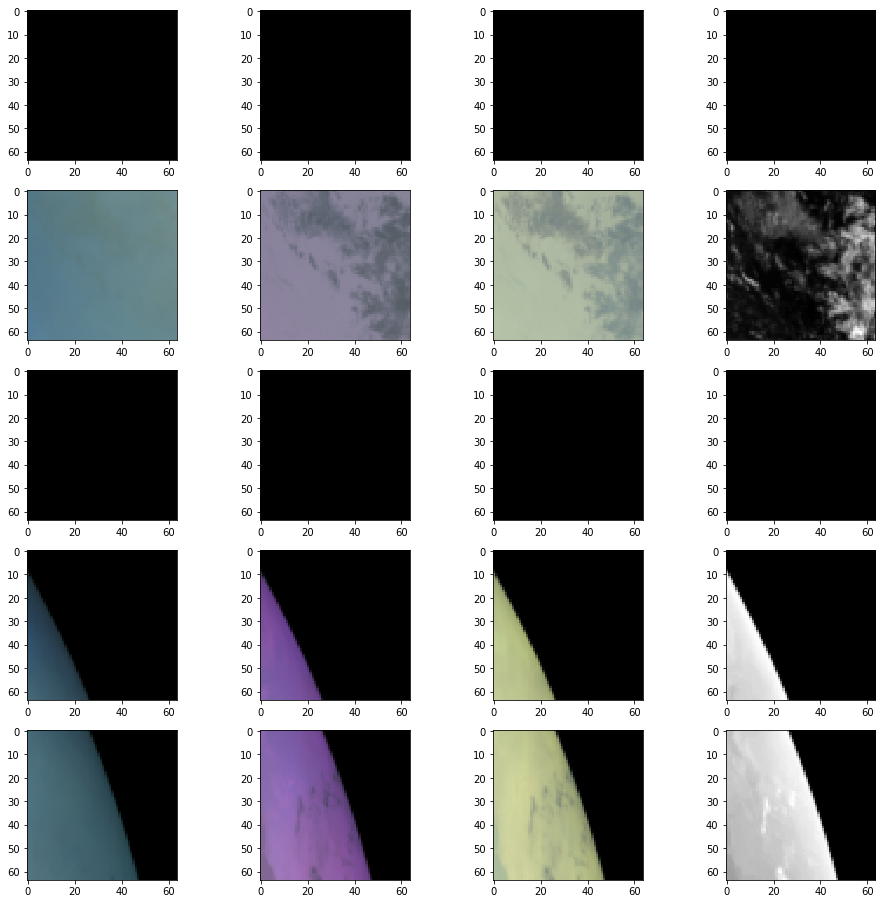

In [3]:
MAX_COLOR_VALUE = 255.9

CLOUD_MASK_FEATURE_NAME = 'cloud-mask'
IR_CHANNELS_FEATURE_NAME = 'ir-channels'

def make_dataset(
    pattern: Text,
    tile_size: int = 64,
    batch_size: int = 8,
    num_map_threads: int = 16,
    mode: tf.estimator.ModeKeys = tf.estimator.ModeKeys.TRAIN) -> tf.data.Dataset:
  """Create a dataset.
  
  Args:
    pattern: file input pattern.
    tile_size: size of the input tiles.
    
  Returns:
    A tf.data.Dataset
  """
  example_fmt = {
      CLOUD_MASK_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 1), tf.int64),
      IR_CHANNELS_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 9), tf.int64),
  }

  def parse_fn(example: Text) -> Tuple[Dict[Text, tf.Tensor], tf.Tensor]:
    parsed = tf.parse_single_example(example, example_fmt)
    raster_in_img = parsed[IR_CHANNELS_FEATURE_NAME]
    raster_out_img = parsed[CLOUD_MASK_FEATURE_NAME]
    raster_in_img = tf.cast(raster_in_img, tf.float32) / 256
    raster_out_img = tf.cast(raster_out_img, tf.float32) / 256
    return raster_in_img, raster_out_img

  is_training = mode == tf.estimator.ModeKeys.TRAIN
  ds = tf.data.Dataset.list_files(pattern, shuffle=is_training)
  ds = ds.repeat()
  ds = ds.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=8)
  ds = ds.shuffle(batch_size * 16)
  ds = ds.map(map_func=parse_fn, num_parallel_calls=num_map_threads)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(32)
  return ds

def print_dataset(pattern):
  ds = make_dataset(pattern)  
  next = ds.make_one_shot_iterator().get_next()
  
  plt.figure(figsize=(16, 16))
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
    raster_in_img = (raster_in_img[0:5, :, :, :] * MAX_COLOR_VALUE).astype(np.uint8)
    raster_out_img = (raster_out_img * MAX_COLOR_VALUE).astype(np.uint8)
    for i in range(5):
      for j in range(3):
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
      ax = plt.subplot(5, 4, i * 4 + 4)
      ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
  plt.show()
  
print_dataset(TRAIN_PATH)  

# Model hyperparameters

Now let's set up the ML problem.  First, we use the `tf.contrib.training.HParams` package to set up model hyperparameters.  These includes values like the learning rate, number of training steps, as well as the model architecture.  We'll use a CNN with `num_layers` layers.

In [4]:
def default_hparams(**kwargs: Any) -> tf.contrib.training.HParams:
  """Create default hyper-parameters for training a model.

  Args:
    **kwargs: default hyper-parameter values to override.

  Returns:
    HParams object with all hyperparameter values.
  """
  hparams = tf.contrib.training.HParams(
      model_dir='gs://weather-datasets/model',
      train_data_path=TRAIN_PATH,
      eval_data_path=TEST_PATH,
      train_batch_size=32,
      learning_rate=1e-3,
      train_steps=10000,
      num_eval_records=128,
      num_cores=8,
      tile_size=64,
      
      # CNN
      kernel_size=5,
      num_filters=16,
      num_layers=3,
  )
  hparams.override_from_dict(kwargs)
  return hparams

hparams = default_hparams()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Create the model

The `create_model` function uses the Keras framework to construct a convolutional neural network.  This is a pretty typical model.  The `train_and_evaluate` function uses `model.compile` to compile the model, then `model.fit` to perform the training.

In [0]:
def create_model(hparams: tf.contrib.training.HParams, img: tf.Tensor) -> tf.Tensor:
  kernel_size = hparams.kernel_size
  num_filters = hparams.num_filters
  num_layers = hparams.num_layers
  cnn = keras.layers.BatchNormalization()(img)
  for layer in range(num_layers):
    cnn = keras.layers.Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(cnn)
    cnn = keras.layers.Activation('elu')(cnn)
    cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.Conv2D(1, (kernel_size, kernel_size), padding='same')(cnn)
  cnn = keras.layers.Activation('relu')(cnn)
  return cnn

def train_and_evaluate(hparams: tf.contrib.training.HParams) -> keras.Model:
  model_dir = hparams.model_dir
  max_steps = hparams.train_steps
  
  # Limit the epoch size.
  steps_per_epoch = min(1000, max_steps // 10)
  num_epochs = max(1, max_steps // steps_per_epoch)
  
  # eval batch size has to be divisible by num_cores
  eval_batch_size = min(hparams.num_eval_records, hparams.train_batch_size)
  eval_batch_size = eval_batch_size - eval_batch_size % hparams.num_cores
  eval_steps = hparams.num_eval_records // eval_batch_size
  tf.logging.info('train_batch_size=%d eval_batch_size=%d train_steps=%d (%d x %d) eval_steps=%d',
                  hparams.train_batch_size, eval_batch_size,
                  max_steps, steps_per_epoch, num_epochs,
                  eval_steps)
  
  # Build the model
  input_img = keras.Input(shape=(hparams.tile_size, hparams.tile_size, 9))
  cnn = create_model(hparams, input_img)
  model = keras.Model(input_img, cnn)
  optimizer = keras.optimizers.Adam(lr=hparams.learning_rate, clipnorm=1.)
  model.compile(optimizer=optimizer,
                loss=keras.losses.mean_absolute_error,
                metrics=['accuracy', 'mse'])

  # Make the datasets
  train_ds = make_dataset(
      hparams.train_data_path,
      mode=tf.estimator.ModeKeys.TRAIN,
      batch_size=hparams.train_batch_size)
  eval_ds = make_dataset(
      hparams.eval_data_path,
      mode=tf.estimator.ModeKeys.EVAL,
      batch_size=eval_batch_size)
  
  # train and evaluate
  start_timestamp = time.time()
  history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=eval_ds,
    validation_steps=eval_steps,
    verbose=1 # 1=progress 2=one line per epoch
  )
  elapsed_time = int(time.time() - start_timestamp)
  tf.logging.info('Finished training up to step %d. Elapsed seconds %d.',
                  max_steps, elapsed_time)
  # tf.logging.info(model.summary())
  print("if running interactively, graph: {}".format(history.history.keys()))
  
  return model

# Train the model

In [6]:
model = train_and_evaluate(hparams)

INFO:tensorflow:train_batch_size=32 eval_batch_size=32 train_steps=10000 (1000 x 10) eval_steps=4
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 53s 53ms/step - loss: 3.0088 - acc: 0.2158 - mean_squared_error: 0.0222 - val_loss: 2.5955 - val_acc: 0.2030 - val_mean_squared_error: 0.0137
Epoch 2/10
1000/1000 [==============================] - 55s 55ms/step - loss: 2.4780 - acc: 0.2148 - mean_squared_error: 0.0129 - val_loss: 2.1701 - val_acc: 0.2049 - val_mean_squared_error: 0.0095
Epoch 3/10
1000/1000 [==============================] - 36s 36ms/step - loss: 2.3400 - acc: 0.2178 - mean_squared_error: 0.0115 - val_loss: 2.4692 - val_acc: 0.1497 - val_mean_squared_error: 0.0121
Epoch 4/10
1000/1000 [==============================] - 36s 36ms/step - loss: 2.2234 - acc: 0.2193 - mean_squared_error: 0.0106 - val_loss: 2.5208 - val_acc: 0.1473 - val_mean_squared_erro

# Display the prediction

Now, let's apply the model on the test data to see what the inferred cloud mask looks like.  The fourth column shows the actual cloud mask created from the blue channel.  The fifth column shows the predicted cloud mask as generated by the ML model.  Looks pretty good!

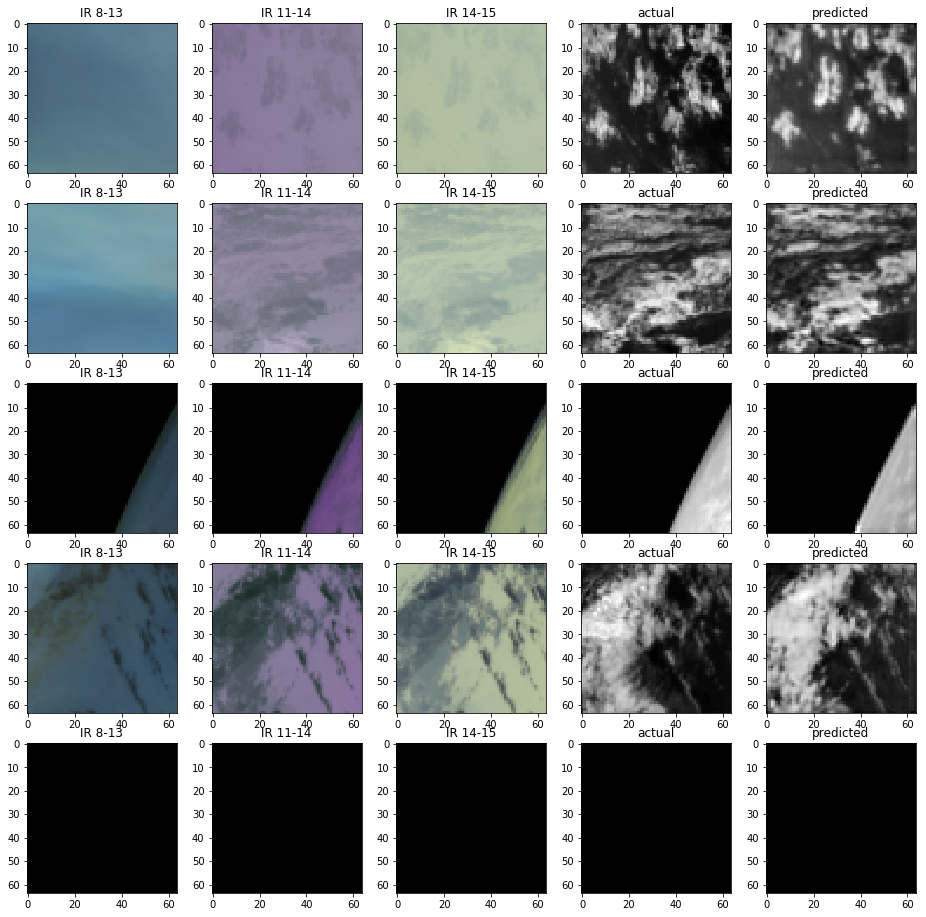

In [16]:
def show_prediction(model: keras.Model, hparams: tf.contrib.training.HParams):
  batch_size = 8
  ds = make_dataset(TEST_PATH, batch_size=batch_size)  
  next = ds.make_one_shot_iterator().get_next()
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
  predict_out_img = model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
      plt.title('IR {}-{}'.format(j * 3 + 8, j + 3 + 10))
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
    plt.title('actual')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    plt.title('predicted')
  plt.show()
    
show_prediction(model, hparams)

# Export the model to a file

We're done!  Let's export the model to a file so that we can reuse it in the next colal [Truecolor_3](https://colab.research.google.com/drive/1X_cqInqx_QjelsScxWnM53PxMhB-5mM4?authuser=2#scrollTo=zzZSrQiNI_l7), where we will apply the model to full-sized images.

In [8]:
def export_keras(model: keras.Model, hparams: tf.contrib.training.HParams) -> Text:
  export_path = tf.contrib.saved_model.save_keras_model(
      model, os.path.join(hparams.model_dir, 'export/exporter'))
  export_path = export_path.decode('utf-8')
  tf.logging.info('Model exported successfully to %s', export_path)
  return export_path
  
export_path = export_keras(model, hparams)


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://weather-datasets/model/export/exporter/1558301458/saved_model.pb
INFO:tensorflow:Model exported successfully to gs://weather-datasets/model/export/exporter/1558301458


INFO:tensorflow:Loading model from gs://weather-datasets/model/export/exporter/1558301458


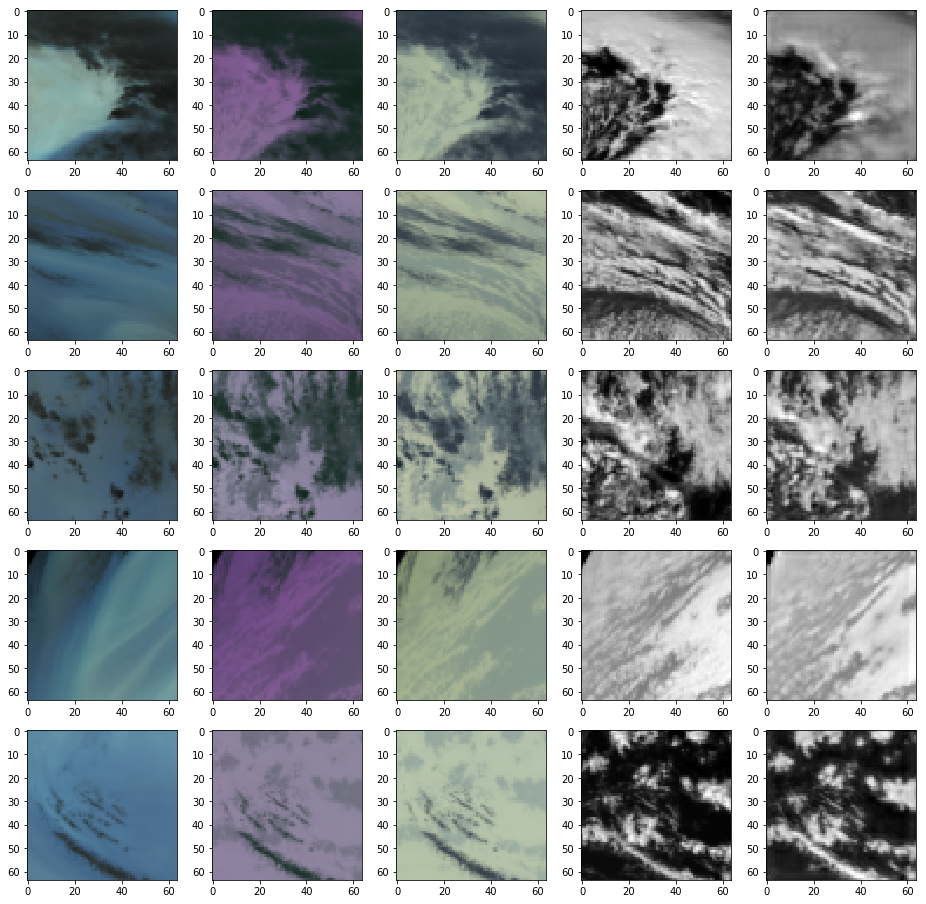

In [9]:
def show_prediction_from_saved_model(model_file: Text, hparams: tf.contrib.training.HParams):
  tf.logging.info('Loading model from %s', model_file)
  saved_model = tf.contrib.saved_model.load_keras_model(model_file)
  
  batch_size = 8
  ds = make_dataset(TRAIN_PATH, batch_size=batch_size)  
  next = ds.make_one_shot_iterator().get_next()
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
  
  predict_out_img = saved_model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    
show_prediction_from_saved_model(export_path, hparams)